# Lorenz system

$$
\dot{x} = s(y - x),\quad \dot{y} = x (r - z) - y, \quad \dot{z} = xy - bz
$$
平衡点のHopf分岐で生じるリミットサイクルを追跡する

In [1]:
import numpy as np
from scipy.optimize import newton
from scipy.integrate import ode
from scipy.linalg import solve, eigvals
import pathfollowing as pf
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set('poster', 'whitegrid', 'dark', rc={"lines.linewidth": 2, 'grid.linestyle': '-'})
import warnings
warnings.filterwarnings('ignore')

In [2]:
def f(x, a):
    s = 10.0
    b = 8.0/3.0
    r = a[0]
    return np.array([s*(x[1]-x[0]), x[0]*(r - x[2])-x[1], x[0]*x[1]-b*x[2]])

def fx(x, a):
    s = 10.0
    b = 8.0/3.0
    r = a[0]
    return np.array([[-s,s,0.0],[r-x[2],-1.0,-x[0]], [x[1],x[0],-b]])

def fa(x,a):
    return np.array([0.0, x[0], 0.0])

## Hopf分岐の検出

In [3]:
x=np.array([0.0, 0.0, 0.0])
a=np.array([0.0])
bd,bp,lp,hb=pf.pathfollow(x, a, f, fx, fa, nmax=300, h=0.1, epsr=1.0e-10, epsb=1.0e-10, problem='equilibria', quiet=True)

In [4]:
v2 = pf.calcSwitchingVectorBP(bd[bp[0]], f, fx, fa)
x2=bd[bp[0]]['x']
a2=bd[bp[0]]['a']
bd2,bp2,lp2, hb2=pf.pathfollow(x2, a2, f, fx, fa, w=v2, nmax=800, h=-0.05, epsr=1.0e-10, epsb=1.0e-10, problem='equilibria', quiet=True)
bd3,bp3,lp3, hb3=pf.pathfollow(x2, a2, f, fx, fa, w=v2, nmax=800, h=0.05, epsr=1.0e-10, epsb=1.0e-10,problem='equilibria', quiet=True)

Hopf分岐点が検出されている

In [5]:
print(bp, hb2, hb3)

[11] [728] [728]


In [6]:
bd_r = np.array([bd[m]['a'][0] for m in range(len(bd))])
bd_x = np.array([bd[m]['x'][0] for m in range(len(bd))])
bd_r2 = np.array([bd2[m]['a'][0] for m in range(len(bd2))])
bd_x2 = np.array([bd2[m]['x'][0] for m in range(len(bd2))])
bd_r3 = np.array([bd3[m]['a'][0] for m in range(len(bd3))])
bd_x3 = np.array([bd3[m]['x'][0] for m in range(len(bd3))])

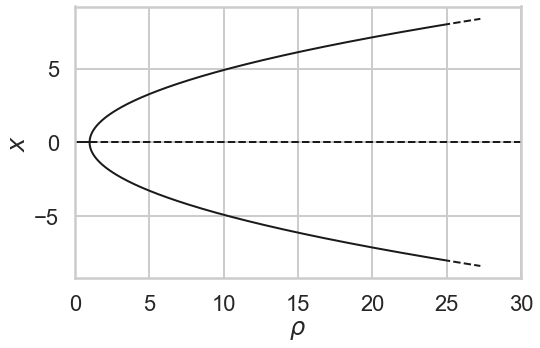

In [7]:
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
ax.set_xlim(0,30)
ax.set_xlabel(r"$\rho$")
ax.set_ylabel("$x$")
ax.plot(bd_r[:11], bd_x[:11], '-k')
ax.plot(bd_r[11:], bd_x[11:], '--k')
ax.plot(bd_r2[:728], bd_x2[:728], '-k')
ax.plot(bd_r2[728:], bd_x2[728:], '--k')
ax.plot(bd_r3[:728], bd_x3[:728], '-k')
ax.plot(bd_r3[728:], bd_x3[728:], '--k')
# plt.savefig("bd_lrz.pdf", bbox_inches='tight')

## リミットサイクルの枝に切り替える

有限差分法を用いる

In [8]:
Npts = 64
def func(x, a):
    T = x[-1]
    h = 1.0 / Npts
    n = (len(x) - 1) // Npts
    ss = np.sin([2*np.pi*j*h for j in range(Npts)])
    y = np.zeros(len(x))
    # tau_0 = 0
    y[:n] = (x[n:2*n] - x[(Npts-1)*n:Npts*n])*0.5/h - T * f(x[:n], a)
    # tau_1 ... tau_{N-2}
    for j in range(1, Npts-1):
        y[j*n:(j+1)*n] = (x[(j+1)*n:(j+2)*n] - x[(j-1)*n:j*n])*0.5/h - T * f(x[j*n:(j+1)*n], a)
    # tau_{N-1} = (N-1) * h
    y[(Npts-1)*n:Npts*n] = (x[:n] - x[(Npts-2)*n:(Npts-1)*n])*0.5/h - T * f(x[(Npts-1)*n:Npts*n], a)
    # Phase condition
    y[-1] = x[:-1:n] @ ss
    return y

def dfdx(x, a):
    T = x[-1]
    n = (len(x)-1) // Npts
    h = 1.0 / Npts
    A = np.zeros((len(x), len(x)))
    I = np.identity(n)
    # j = 0
    A[:n, n:2*n] += I * 0.5 / h
    A[:n, (Npts-1)*n:Npts*n] -= I * 0.5 / h
    A[:n,:n] += -T * fx(x[:n], a)
    A[:n,-1] += -f(x[:n], a)
    # j = 1 ... N-2
    for j in range(1, Npts-1):
        A[j*n:(j+1)*n, (j+1)*n:(j+2)*n] += I * 0.5 / h
        A[j*n:(j+1)*n, (j-1)*n:j*n] -= I * 0.5 / h
        A[j*n:(j+1)*n, j*n:(j+1)*n] += -T * fx(x[j*n:(j+1)*n], a)
        A[j*n:(j+1)*n, -1] = -f(x[j*n:(j+1)*n], a)
    # j = N - 1
    A[(Npts-1)*n:Npts*n, :n] += I * 0.5 / h
    A[(Npts-1)*n:Npts*n, (Npts-2)*n:(Npts-1)*n] -= I * 0.5 / h
    A[(Npts-1)*n:Npts*n, (Npts-1)*n:Npts*n] += -T*fx(x[(Npts-1)*n:Npts*n], a)
    A[(Npts-1)*n:Npts*n, -1] += -f(x[(Npts-1)*n:Npts*n], a)
    # Phase condition
    A[-1, :-1:n] = np.sin([2*np.pi*j*h for j in range(Npts)])
    return A

def dfda(x, a):
    T = x[-1]
    n = (len(x) - 1) // Npts
    h = 1.0 / Npts
    b = np.zeros(len(x))
    for j in range(Npts):
        b[j*n:(j+1)*n] = -T*fa(x[j*n:(j+1)*n], a)
    return b

In [9]:
vr = bd2[hb2[0]]['vr']
vi = bd2[hb2[0]]['vi']
vr /= np.sqrt(vr@vr)
vi /= np.sqrt(vi@vi)
rr = np.hypot(vr, vi)
tt = np.array([np.angle(vr[i]+1.j*vi[i]) for i in range(len(vr))])
ev = eigvals(fx(bd2[hb2[0]-1]['x'], bd2[hb2[0]-1]['a']))

In [10]:
print(np.linalg.norm(vr), np.linalg.norm(vi))

1.0 1.0


In [11]:
x = np.zeros(3*Npts+1)
da = np.abs(bd2[hb2[0]]['a'][0] - bd2[hb2[0]-1]['a'][0])
for j in range(Npts):
    x[3*j:3*(j+1)] = bd2[hb2[0]-1]['x'] + 10 * np.sqrt(da) * rr * np.cos(2*np.pi*j/Npts + tt - tt[0])
x[-1] = 2*np.pi/np.imag(ev[1])

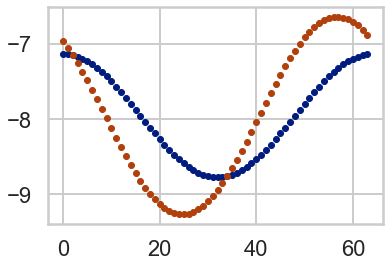

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x[:-1:3],'.')
ax.plot(x[1:-1:3],'.')

ニュートン法で追跡の初期値を捉える

In [13]:
y = np.copy(x)
a = bd2[hb2[0]-1]['a']
for m in range(10):
    b = func(y, a)
    A = dfdx(y, a)
    y -= solve(A, b)
    print(np.linalg.norm(b))
# x = np.copy(y)
print(y)

17.452358228289558
0.5830025083231322
0.036898144775377485
0.0034380266876737377
1.878379692733781e-05
4.3697882154166163e-10
4.046114887768039e-13
3.9831118164799507e-13
4.161169284809889e-13
4.314885606483114e-13
[-7.53738638 -7.54091901 23.23027801 -7.53962977 -7.5799635  23.18034867
 -7.54561108 -7.62231997 23.13516858 -7.55527194 -7.66763967 23.09513782
 -7.56852467 -7.71555057 23.06061826 -7.58525289 -7.76565865 23.03193102
 -7.60531231 -7.81754936 23.00935379 -7.62853145 -7.87078919 22.99311819
 -7.65471256 -7.92492749 22.98340712 -7.68363262 -7.97949853 22.98035215
 -7.71504439 -8.03402395 22.98403102 -7.74867769 -8.08801556 22.99446522
 -7.78424084 -8.14097858 23.01161785 -7.82142226 -8.19241532 23.03539167
 -7.8598923  -8.24182935 23.06562765 -7.89930538 -8.28873008 23.10210386
 -7.93930227 -8.33263787 23.14453502 -7.97951284 -8.37308945 23.19257268
 -8.01955888 -8.40964375 23.24580617 -8.05905743 -8.44188791 23.3037644
 -8.09762419 -8.46944348 23.36591862 -8.13487737 -8.4919

ニュートン法の初期値と最終値

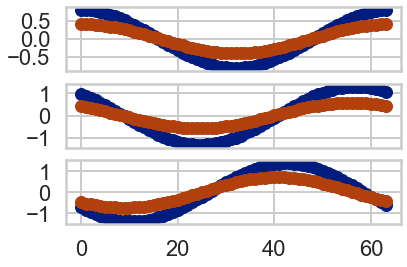

In [14]:
fig = plt.figure()
ax = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)
ax.plot(x[:-1:3]-bd2[hb2[0]-1]['x'][0],'o-')
ax.plot(y[:-1:3]-bd2[hb2[0]-1]['x'][0],'o-')
ax2.plot(x[1:-1:3]-bd2[hb2[0]-1]['x'][1],'o-')
ax2.plot(y[1:-1:3]-bd2[hb2[0]-1]['x'][1],'o-')
ax3.plot(x[2:-1:3]-bd2[hb2[0]-1]['x'][2],'o-')
ax3.plot(y[2:-1:3]-bd2[hb2[0]-1]['x'][2],'o-')

リミットサイクルの追跡

In [16]:
x = np.copy(y)
bdc,bpc,lpc=pf.pathfollow(x, a, func, dfdx, dfda, nmax=120, h=-1.0, epsr=1.0e-10, epsb=1.0e-10, problem=None, quiet=True)

In [17]:
bdc_r = np.array([bdc[m]['a'][0] for m in range(len(bdc))])
bdc_xmax = np.array([np.max(bdc[m]['x'][:-1:3]) for m in range(len(bdc))])
bdc_xmin = np.array([np.min(bdc[m]['x'][:-1:3]) for m in range(len(bdc))])

もう一つの平衡点から分岐するリミットサイクル

In [18]:
vr = bd3[hb3[0]]['vr']
vi = bd3[hb3[0]]['vi']
vr /= np.sqrt(vr@vr)
vi /= np.sqrt(vi@vi)
rr = np.hypot(vr, vi)
tt = np.array([np.angle(vr[i]+1.j*vi[i]) for i in range(len(vr))])
ev = eigvals(fx(bd3[hb3[0]-1]['x'], bd3[hb3[0]-1]['a']))

In [19]:
x = np.zeros(3*Npts+1)
da = np.abs(bd3[hb3[0]]['a'][0] - bd3[hb3[0]-1]['a'][0])
for j in range(Npts):
    x[3*j:3*(j+1)] = bd3[hb3[0]-1]['x'] + 10 * np.sqrt(da) * rr * np.cos(2*np.pi*j/Npts + tt - tt[0])
x[-1] = 2*np.pi/np.imag(ev[1])

In [20]:
y = np.copy(x)
a = bd3[hb3[0]-1]['a']
for m in range(10):
    b = func(y, a)
    A = dfdx(y, a)
    y -= solve(A, b)
    print(np.linalg.norm(b))

17.452358228289576
0.5830025083230712
0.036898144775363816
0.0034380266875918084
1.8783796926681597e-05
4.3698744907152453e-10
4.5241060798681457e-13
4.405317554253044e-13
3.9296963826199675e-13
4.589396161542513e-13


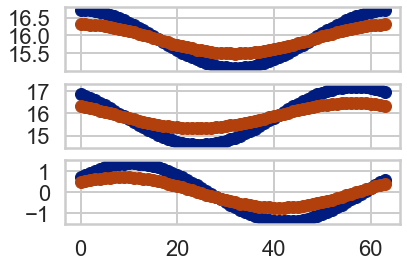

In [21]:
fig = plt.figure()
ax = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)
ax.plot(x[:-1:3]-bd2[hb2[0]-1]['x'][0],'o-')
ax.plot(y[:-1:3]-bd2[hb2[0]-1]['x'][0],'o-')
ax2.plot(x[1:-1:3]-bd2[hb2[0]-1]['x'][1],'o-')
ax2.plot(y[1:-1:3]-bd2[hb2[0]-1]['x'][1],'o-')
ax3.plot(x[2:-1:3]-bd2[hb2[0]-1]['x'][2],'o-')
ax3.plot(y[2:-1:3]-bd2[hb2[0]-1]['x'][2],'o-')

In [22]:
x = np.copy(y)
bdc2,bpc2,lpc2=pf.pathfollow(x, a, func, dfdx, dfda, nmax=120, h=-1.0, epsr=1.0e-10, epsb=1.0e-10, problem=None, quiet=True)

In [23]:
bdc2_r = np.array([bdc2[m]['a'][0] for m in range(len(bdc2))])
bdc2_xmax = np.array([np.max(bdc2[m]['x'][:-1:3]) for m in range(len(bdc2))])
bdc2_xmin = np.array([np.min(bdc2[m]['x'][:-1:3]) for m in range(len(bdc2))])

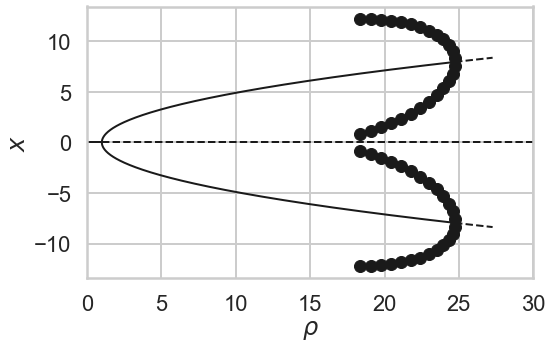

In [24]:
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
ax.set_xlim(0,30)
ax.set_xlabel(r"$\rho$")
ax.set_ylabel("$x$")
ax.plot(bd_r[:11], bd_x[:11], '-k')
ax.plot(bd_r[11:], bd_x[11:], '--k')
ax.plot(bd_r2[:728], bd_x2[:728], '-k')
ax.plot(bd_r2[728:], bd_x2[728:], '--k')
ax.plot(bd_r3[:728], bd_x3[:728], '-k')
ax.plot(bd_r3[728:], bd_x3[728:], '--k')
ax.plot(bdc_r[::10], bdc_xmax[::10], 'o-k')
ax.plot(bdc_r[::10], bdc_xmin[::10], 'o-k')
ax.plot(bdc2_r[::10], bdc2_xmax[::10], 'o-k')
ax.plot(bdc2_r[::10], bdc2_xmin[::10], 'o-k')
# plt.savefig("bd_lrz_hopf.pdf", bbox_inches='tight')